In [2]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import random

In [3]:
execfile('ML_Challenge_data_preprocessing.py')

('Generated X with shape ', (347698, 1000))
('Generated y with shape ', (347698,))


In [4]:
first_seq_label, second_seq_label = [y[9],y[5]]
print 'Labels are: ' + str(first_seq_label) + ' and ' + str(second_seq_label)

Labels are: 0 and 0


In [6]:
execfile('longest_common_subsequence.py')
seq1, seq2 = X[9], X[5]
print 'Start of seq1: ' + str(seq1[0:5])
print 'Start of seq2: ' + str(seq2[0:5])

score = longest_common_subsequence_score(seq1, seq2)
print 'Score for longest common subsequence: ' + str(score)

Start of seq1: ['G' 'C' 'T' 'G' 'G']
Start of seq2: ['T' 'T' 'G' 'G' 'C']
Score for longest common subsequence: 655.0


In [7]:
# split into promotors and enhancers
promoter_idcs = (y == 0).nonzero()[0]
num_promoters = len(promoter_idcs)
enhancer_idcs = (y == 1).nonzero()[0]
num_enhancers = len(enhancer_idcs)
assert(num_promoters + num_enhancers == X.shape[0])
promoter_X = X[promoter_idcs,]
enhancer_X = X[enhancer_idcs,]
print promoter_X.shape
print enhancer_X.shape

(274299, 1000)
(73399, 1000)


In [8]:
def compute_scores(num_pairs, X1, X2):
    scores = []
    for i in range(num_pairs):
        if i % 5 == 0: print 'Evaluating pair ' + str(i)
        random_idx1 = int(random.random()*X1.shape[0])
        random_idx2 = int(random.random()*X2.shape[0])
        # although this doesn't matter if X1 != X2
        assert(random_idx1 != random_idx2)
        seq1 = X1[random_idx1]
        seq2 = X2[random_idx2]
        score = longest_common_subsequence_score(seq1, seq2)
        scores.append(score)
    return scores

In [9]:
num_pairs = 100
both_label0_seq_scores = compute_scores(num_pairs, promoter_X, promoter_X)
print both_label0_seq_scores[0:10]

Evaluating pair 0
Evaluating pair 5
Evaluating pair 10
Evaluating pair 15
Evaluating pair 20
Evaluating pair 25
Evaluating pair 30
Evaluating pair 35
Evaluating pair 40
Evaluating pair 45
Evaluating pair 50
Evaluating pair 55
Evaluating pair 60
Evaluating pair 65
Evaluating pair 70
Evaluating pair 75
Evaluating pair 80
Evaluating pair 85
Evaluating pair 90
Evaluating pair 95
[622.0, 627.0, 634.0, 628.0, 622.0, 619.0, 635.0, 633.0, 635.0, 658.0]


In [10]:
both_label1_seq_scores = compute_scores(num_pairs, enhancer_X, enhancer_X)
print both_label1_seq_scores[0:10]

Evaluating pair 0
Evaluating pair 5
Evaluating pair 10
Evaluating pair 15
Evaluating pair 20
Evaluating pair 25
Evaluating pair 30
Evaluating pair 35
Evaluating pair 40
Evaluating pair 45
Evaluating pair 50
Evaluating pair 55
Evaluating pair 60
Evaluating pair 65
Evaluating pair 70
Evaluating pair 75
Evaluating pair 80
Evaluating pair 85
Evaluating pair 90
Evaluating pair 95
[608.0, 622.0, 641.0, 664.0, 635.0, 603.0, 629.0, 601.0, 624.0, 634.0]


In [11]:
diff_label_seq_scores = compute_scores(num_pairs, enhancer_X, promoter_X)
print diff_label_seq_scores[0:10]

Evaluating pair 0
Evaluating pair 5
Evaluating pair 10
Evaluating pair 15
Evaluating pair 20
Evaluating pair 25
Evaluating pair 30
Evaluating pair 35
Evaluating pair 40
Evaluating pair 45
Evaluating pair 50
Evaluating pair 55
Evaluating pair 60
Evaluating pair 65
Evaluating pair 70
Evaluating pair 75
Evaluating pair 80
Evaluating pair 85
Evaluating pair 90
Evaluating pair 95
[553.0, 629.0, 609.0, 566.0, 641.0, 602.0, 628.0, 630.0, 604.0, 586.0]


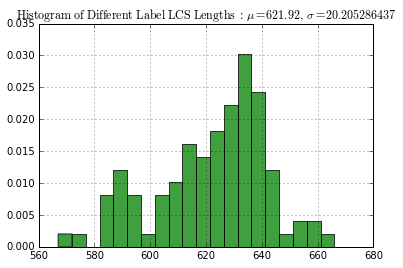

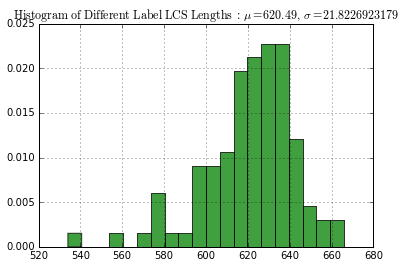

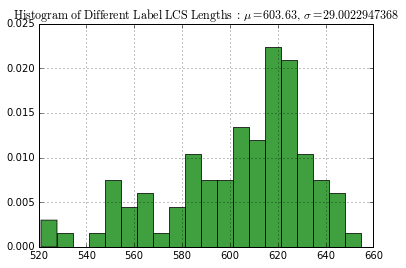

In [12]:
%matplotlib inline

def plot_lcs_lengths(seq_lengths):
    n, bins, patches = plt.hist(seq_lengths, 20, normed=1, facecolor='green', alpha=0.75)
    mu = np.mean(seq_lengths)
    sigma = np.std(seq_lengths)
    plt.title(r'$\mathrm{Histogram\ of\ Different\ Label\ LCS\ Lengths\ :}\ \mu='
              '' + str(mu) + ',\ \sigma=' + str(sigma) + '$')
    # Note: there is a value lower, ths has cut some extremes
    plt.grid(True)
    plt.show()

plot_lcs_lengths(both_label0_seq_scores)
plot_lcs_lengths(both_label1_seq_scores)
plot_lcs_lengths(diff_label_seq_scores)

In [13]:
import numpy as np

def classify(sequence, num_comparisons,
             num_neighbors = 10.0,
             stat = 'majority_vote',
             alignment_algorithm = 'longest_common_subsequence_score'):
    random_promoter_indcs = np.random.choice(len(promoter_X), num_comparisons)
    random_enhancer_indcs = np.random.choice(len(enhancer_X), num_comparisons)
    enhancer_scores = []
    promoter_scores = []
    for i in range(num_comparisons):
        enhancer = enhancer_X[random_enhancer_indcs[i],:]
        score_enh = eval(alignment_algorithm + '(enhancer, sequence)')
        enhancer_scores.append(score_enh)
        promoter = promoter_X[random_promoter_indcs[i],:]   
        score_prom = eval(alignment_algorithm + '(promoter, sequence)')
        promoter_scores.append(score_prom)
    promoter_scores.sort()
    enhancer_scores.sort()    
    votes_promoter = 0.0
    for i in range(int(num_neighbors)):
        if promoter_scores[i] > enhancer_scores[i]: votes_promoter += 1
    return 0 if round(votes_promoter/num_neighbors) == 1.0 else 1

In [14]:
# NOTE: we have to ensure we don't train using the same sequence, but this should be ok in cv setup
errors = 0
num_trials = 100
for itera in range(num_trials):
    random_idx = np.random.choice(len(X), 1)[0]
    sequence = X[random_idx,:]
    true_class = y[random_idx]
    print 'True class is ' + str(true_class)

    num_comparisons = 10
    predicted_class = classify(sequence, num_comparisons)
    print 'Predicted class is: ' + str(predicted_class)
    if predicted_class != true_class: errors += 1
    print
    
print 'Final accuracy: ' + str(float(errors)/num_trials)

True class is 0
Predicted class is: 1

True class is 0
Predicted class is: 0

True class is 0
Predicted class is: 0

True class is 0
Predicted class is: 0

True class is 0
Predicted class is: 1

True class is 0
Predicted class is: 0

True class is 1
Predicted class is: 1

True class is 1
Predicted class is: 1

True class is 1
Predicted class is: 1

True class is 1
Predicted class is: 0

True class is 0
Predicted class is: 1

True class is 0
Predicted class is: 0

True class is 0
Predicted class is: 0

True class is 1
Predicted class is: 1

True class is 0
Predicted class is: 0

True class is 1
Predicted class is: 1

True class is 0
Predicted class is: 0

True class is 1


KeyboardInterrupt: 